In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter


In [5]:
df=pd.read_csv('Fraud Detection.csv')

In [6]:
df.head()

,step,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,isFraud,Column1,isFraud - Copy,DayOfWeek,DayOfWeek(new)
0,7,PAYMENT,Espana,1526.50,C1908839976,0.0,0.0,M1304522697,0.0,0.0,7,0,Savings,03-Jan-18,Afternoon,Safe,7168,0.0,3.0,Wednesday
1,7,PAYMENT,Honduras,1620.17,C70432899,0.0,0.0,M252297858,0.0,0.0,2,0,Savings,05-Jan-18,Night,Safe,7211,0.0,5.0,Friday
2,7,PAYMENT,Indonesia,5689.82,C332151172,0.0,0.0,M1430674428,0.0,0.0,3,0,Savings,07-Jan-18,Morning,Safe,7268,0.0,7.0,Sunday
3,7,PAYMENT,Estados Unidos,2211.07,C1148172078,0.0,0.0,M650835126,0.0,0.0,13,0,Savings,06-Jan-18,Afternoon,Safe,7325,0.0,6.0,Saturday
4,7,PAYMENT,Estados Unidos,824.63,C1142006014,0.0,0.0,M745868137,0.0,0.0,7,0,Savings,06-Jan-18,Morning,Safe,7326,0.0,6.0,Saturday


In [7]:
df.shape

(10127, 20)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   step                 10127 non-null  int64  
 1   type                 10123 non-null  object 
 2   branch               10127 non-null  object 
 3   amount               10125 non-null  float64
 4   nameOrig             10121 non-null  object 
 5   oldbalanceOrg        10125 non-null  float64
 6   newbalanceOrig       10127 non-null  float64
 7   nameDest             10121 non-null  object 
 8   oldbalanceDest       10126 non-null  float64
 9   newbalanceDest       10125 non-null  float64
 10  unusuallogin         10127 non-null  int64  
 11  isFlaggedFraud       10127 non-null  int64  
 12  Acct type            10117 non-null  object 
 13  Date of transaction  10120 non-null  object 
 14  Time of day          10125 non-null  object 
 15  isFraud              10127 non-null 

In [9]:
df.isnull().sum()

step                    0
type                    4
branch                  0
amount                  2
nameOrig                6
oldbalanceOrg           2
newbalanceOrig          0
nameDest                6
oldbalanceDest          1
newbalanceDest          2
unusuallogin            0
isFlaggedFraud          0
Acct type              10
Date of transaction     7
Time of day             2
isFraud                 0
Column1                 0
isFraud - Copy          2
DayOfWeek               7
DayOfWeek(new)          7
dtype: int64

In [10]:

df.duplicated().sum()

0

In [11]:
df.type.value_counts()

type
PAYMENT     5541
CASH_IN     1953
CASH_OUT    1337
TRANSFER     946
DEBIT        346
Name: count, dtype: int64

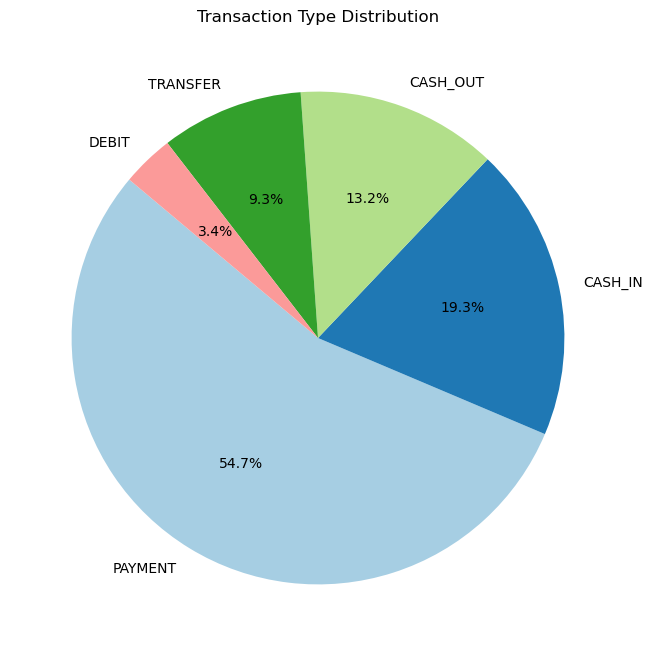

In [12]:
# Pie chart for 'type' column
plt.figure(figsize=(8, 8))
type_counts = df['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Transaction Type Distribution")
plt.show()

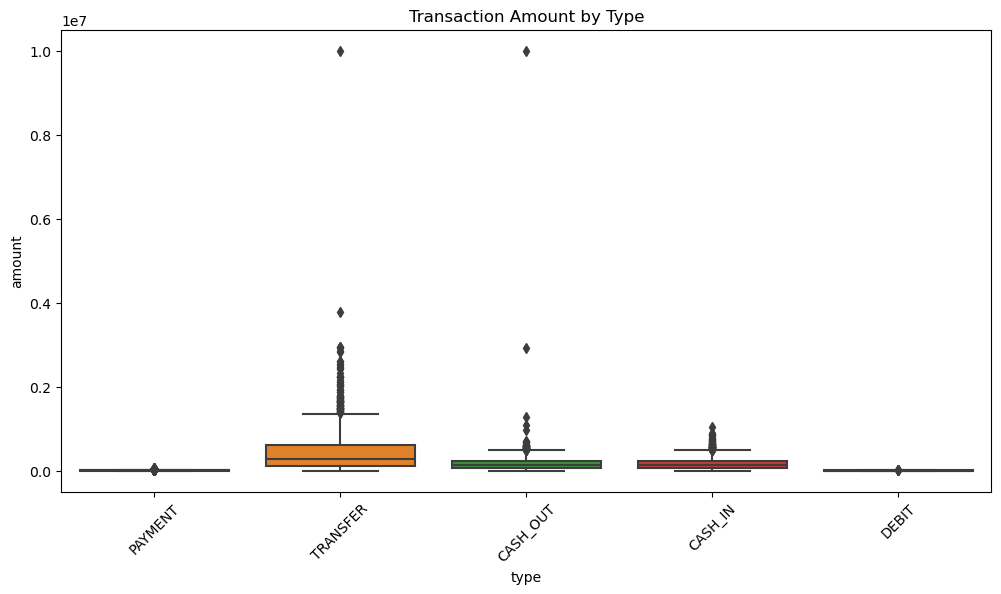

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['type'], y=df['amount'])
plt.title("Transaction Amount by Type")
plt.xticks(rotation=45)
plt.show()

In [14]:
df["isFraud"].value_counts()

isFraud
Safe            10057
Fraud              68
Not reviewed        2
Name: count, dtype: int64

In [15]:
# Keep only rows where 'isFraud' is either 'Safe' or 'Fraud'
df = df[df["isFraud"].isin(["Safe", "Fraud"])]

# Check class distribution after removal
print(df["isFraud"].value_counts())

isFraud
Safe     10057
Fraud       68
Name: count, dtype: int64


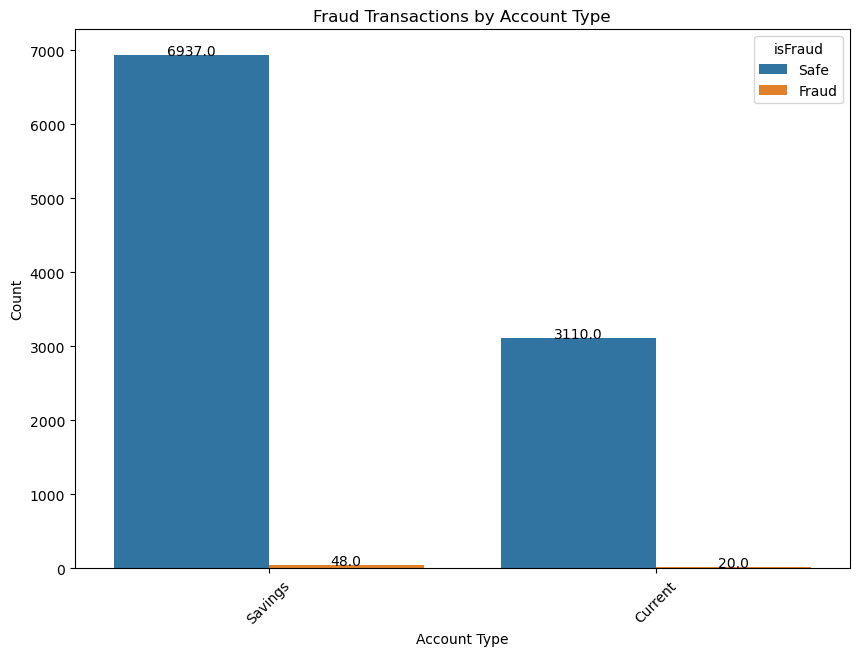

In [16]:
#df["Acct type"].value_counts()
# 10. Fraud Transactions by Account Type
plt.figure(figsize=(10,7))
ax = sns.countplot(x=df['Acct type'], hue=df['isFraud'])
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black')
plt.title("Fraud Transactions by Account Type")
plt.xlabel("Account Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

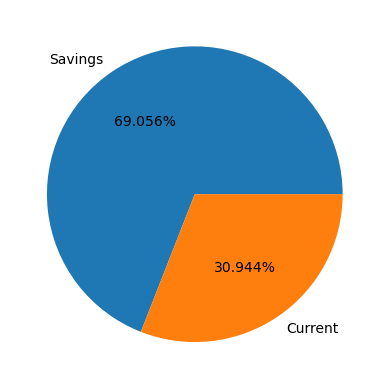

In [17]:
counts = df["Acct type"].value_counts()
labels = counts.index
plt.pie(counts, labels=labels, autopct='%1.3f%%')
plt.show()

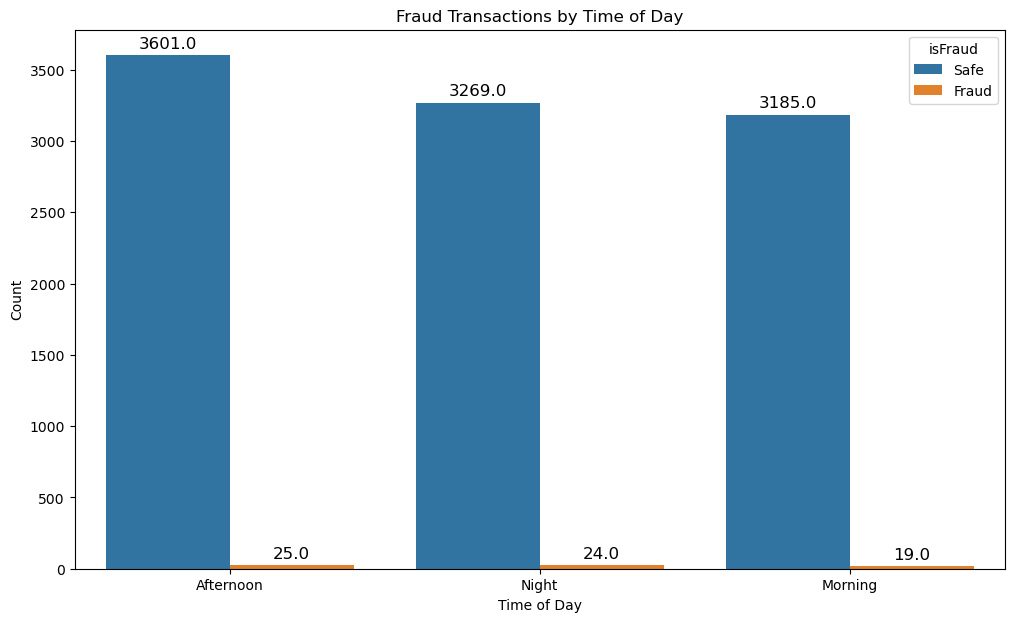

In [18]:

plt.figure(figsize=(12,7))
ax = sns.countplot(x=df['Time of day'], hue=df['isFraud'])
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0,5),
                textcoords='offset points')
plt.title("Fraud Transactions by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.show()

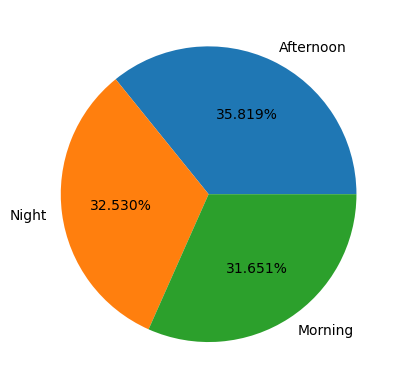

In [19]:
counts = df["Time of day"].value_counts()
labels = counts.index
plt.pie(counts, labels=labels, autopct='%1.3f%%')
plt.show()

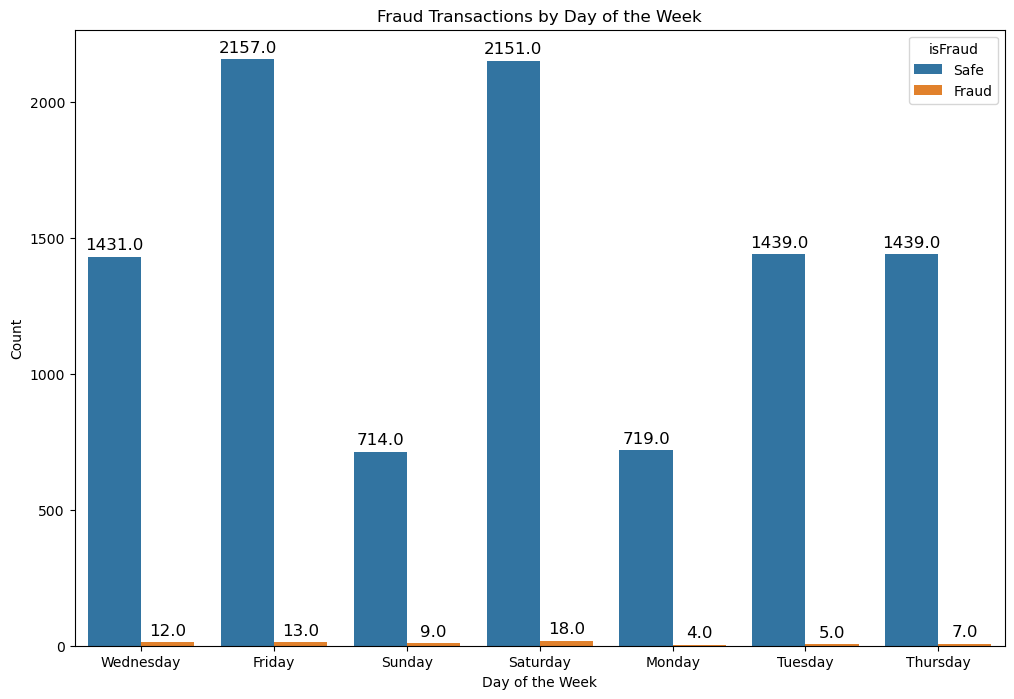

In [20]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df['DayOfWeek(new)'], hue=df['isFraud'])
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0,5),
                textcoords='offset points')
plt.title("Fraud Transactions by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Count")
plt.show()

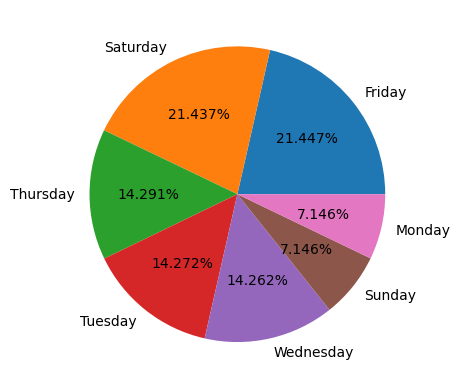

In [21]:
counts = df["DayOfWeek(new)"].value_counts()
labels = counts.index
plt.pie(counts, labels=labels, autopct='%1.3f%%')
plt.show()

C:\Users\sudhanshu  singh\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\sudhanshu  singh\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


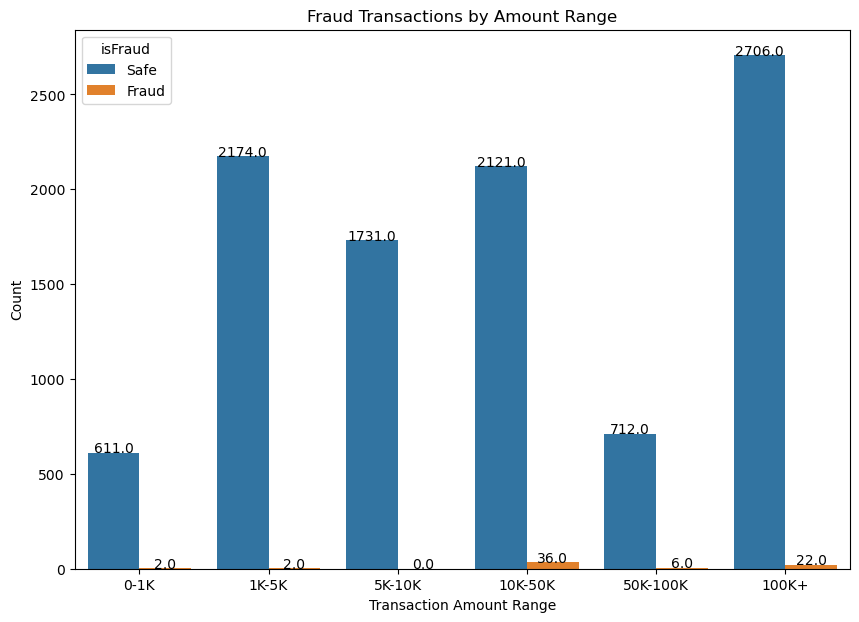

In [22]:
#  Fraud Detection by Transaction Amount Range
bins = [0, 1000, 5000, 10000, 50000, 100000, df['amount'].max()]
labels = ['0-1K', '1K-5K', '5K-10K', '10K-50K', '50K-100K', '100K+']
df['AmountRange'] = pd.cut(df['amount'], bins=bins, labels=labels)
plt.figure(figsize=(10,7))
ax = sns.countplot(x=df['AmountRange'], hue=df['isFraud'])
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=10, color='black')
plt.title("Fraud Transactions by Amount Range")
plt.xlabel("Transaction Amount Range")
plt.ylabel("Count")
plt.show()


In [23]:
# Drop unwanted columns
drop_columns = ["nameDest", "nameOrig", "oldbalanceOrg", "newbalanceOrig", "newbalanceDest", "oldbalanceDest", "payer_type", "step", "datetime", "isFlaggedFraud"]
df = df.drop(columns=drop_columns, errors='ignore')

In [30]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical features in-place (modifying df directly)
le = LabelEncoder()
categorical_cols = ['type', 'branch', 'Acct type', 'Time of day', 'DayOfWeek(new)', 'isFraud']

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))  # Ensuring string type for LabelEncoder

print("Categorical Encoding Completed!")


Categorical Encoding Completed!


In [31]:
# Selecting features
features = ['type', 'branch', 'amount', 'unusuallogin', 'Acct type', 'Time of day', 'DayOfWeek(new)']
target = 'isFraud'


In [26]:
X = df[features]
y = df[target]

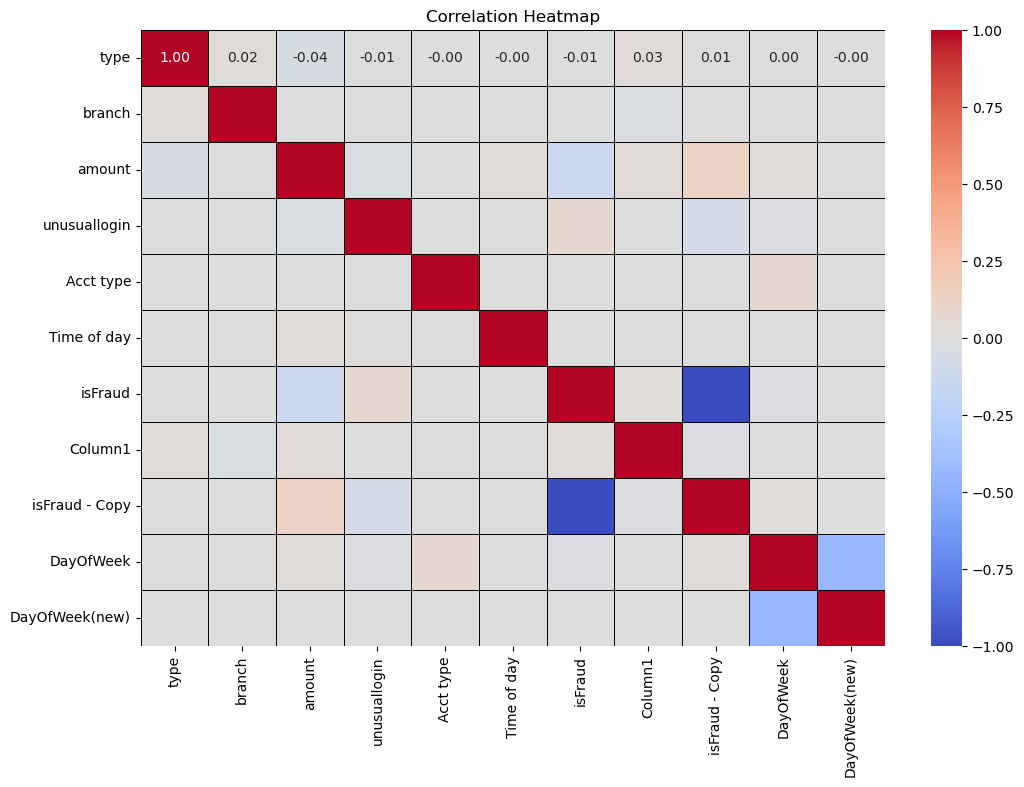

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert date column
df['Date of transaction'] = pd.to_datetime(df['Date of transaction'], errors='coerce')

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

# Generate heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, linecolor='black')
plt.title("Correlation Heatmap")
plt.show()


In [37]:
# Check class distribution
print("Class Distribution before resampling:", Counter(y))

Class Distribution before resampling: Counter({1: 10057, 0: 68})


In [38]:
# Fill missing values for numerical columns with mean
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Fill missing values for categorical columns with mode
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify there are no NaN values left
print(df.isnull().sum())

type                   0
branch                 0
amount                 0
unusuallogin           0
Acct type              0
Date of transaction    7
Time of day            0
isFraud                0
Column1                0
isFraud - Copy         0
DayOfWeek              0
DayOfWeek(new)         0
AmountRange            2
dtype: int64


In [39]:
print("Missing values per column:\n", X.isnull().sum())


Missing values per column:
 type              0
branch            0
amount            2
unusuallogin      0
Acct type         0
Time of day       0
DayOfWeek(new)    0
dtype: int64


In [40]:
X['amount'].fillna(X['amount'].mean(), inplace=True)


C:\Users\sudhanshu  singh\AppData\Local\Temp\ipykernel_9040\2481589207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['amount'].fillna(X['amount'].mean(), inplace=True)


In [41]:

# Handling class imbalance using SMOTE only if minority class has sufficient samples
if len(y[y == 1]) > 5:
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
else:
    X_resampled, y_resampled = X, y

In [42]:
# Check class distribution after resampling
print("Class Distribution after resampling:", Counter(y_resampled))

Class Distribution after resampling: Counter({1: 9152, 0: 9152})


In [43]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [44]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
# Model Training with Cross-Validation
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print("Cross-validation Accuracy Scores:", scores)
print("Mean CV Accuracy:", np.mean(scores))

Cross-validation Accuracy Scores: [0.99009901 0.99112325 0.9897576  0.98941257 0.9897541 ]
Mean CV Accuracy: 0.9900293046546034


In [46]:
# Train final model
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [47]:
# Model Prediction
y_pred = model.predict(X_test)

In [48]:
# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9934444140945097
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1831
           1       1.00      0.99      0.99      1830

    accuracy                           0.99      3661
   macro avg       0.99      0.99      0.99      3661
weighted avg       0.99      0.99      0.99      3661

Confusion Matrix:
 [[1828    3]
 [  21 1809]]


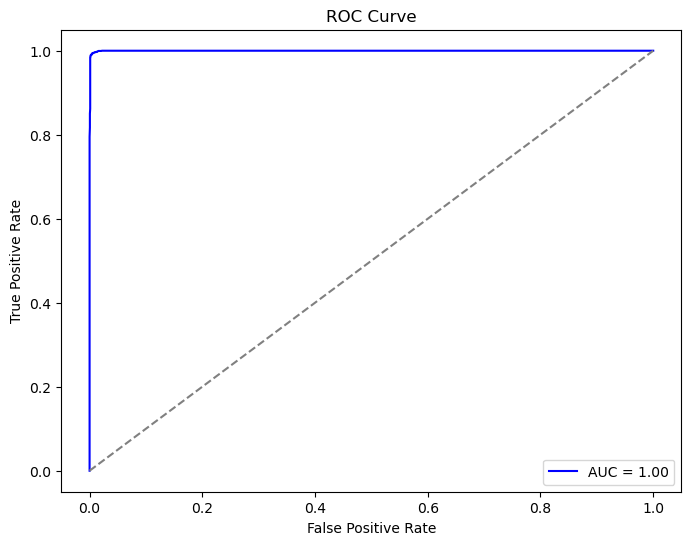

In [49]:
# ROC Curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
